<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

#%config InlineBackend.figure_format = 'retina'
#%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [3]:
# Load the data
house = pd.read_csv('/Users/gopetro/documents/dsi/materials/project3/housing.csv')


#Jeff is running python 2.7

1. View, clean and conduct EDA

In [4]:
#Let's have quick look at header.
house.head()
#Noticed the following:
#NaN values, repeating columns, Id column

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
#Drop Id column
house = house.drop('Id', axis=1)

In [6]:
#Check number of rows and columns
house.shape 

(1460, 80)

In [7]:
#Check unique values in MSZoning and remove rows that are not residential
house.MSZoning.unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [8]:
#This steps answers Question #2. 
#Removing non residential houses

#Only include residential houses
#Use 'MSZoning' as filter
house = house[(house.MSZoning != 'C (all)')] #Removes rows classified as Commercial

In [9]:
#Check shape to confirm rows removed
house.shape #This removed 10 rows

(1450, 80)

In [10]:
#Check the number of different values in a column. If a column has less than 5 unique values then drop column due to lack of variance
house.Street.nunique() # 2 unique values in entire column
house.LandContour.nunique() # 4 unique values in entire column
house.Utilities.nunique() # 2 unique values in entire column
house.LandSlope.nunique() # 3 unique values in entire column
house.PoolQC.nunique() # 3 unique values in entire column
house.BsmtCond.nunique() # 4 unique values in entire column

house = house.drop(['Street','LandContour', 'Utilities', 'LandSlope','PoolQC','BsmtCond']
                   , axis=1)

#The following columns were checked but not dropped
#house.PoolArea.nunique() # 8 unique values in entire column
#house.RoofMatl.nunique() # 8 unique values in entire column
#house.ExterCond.nunique() # 5 unique values in entire column
#house.Heating.nunique() # 6 unique values in entire column
#house.PoolArea.nunique()  # 8 unique values in entire column

In [11]:
#View header information to see if any unusual charcters
list(house)

['MSSubClass',
 'MSZoning',
 'LotFrontage',
 'LotArea',
 'Alley',
 'LotShape',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'Fence',
 '

In [12]:
#View object types
print house.dtypes
#View shape
print house.shape

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Alley             object
LotShape          object
LotConfig         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
                  ...   
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object


In [13]:
house.isnull().sum()

MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Alley            1361
LotShape            0
LotConfig           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
                 ... 
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       681
GarageType         79
GarageYrBlt        79
GarageFinish       79
GarageCars          0
GarageArea          0
GarageQual         79
GarageCond

In [14]:
#After comparing the null values to the data_descriptions.txt file it appears that the term 'NAn' is not null.
#The term NAn refers to something else. See below:

#Alley: NA = No alley access
#BsmtQual: NA = No Basement
#BsmtCond: NA = No Basement
#BsmtFinType1: NA = No Basement
#BsmtFinType2: NA = No Basement
#GarageType: NA = No Garage
#GarageFinish: NA = No Garage
#GarageQual: NA = No Garage
#GarageCond: NA = No Garage
#PoolQC: NA = No Pool
#Fence: NA = No Fence
#MiscFeature = NA = None

#Convert null to appropriate description
#Credit Joseph Nelson

house.Alley = house.Alley.fillna(value='none', inplace=False)
house.BsmtQual = house.BsmtQual.fillna(value='none', inplace=False)
house.BsmtFinType1 = house.BsmtFinType1.fillna(value='none', inplace=False)
house.BsmtFinType2 = house.BsmtFinType2.fillna(value='none', inplace=False)
house.GarageType = house.GarageType.fillna(value='none', inplace=False)
house.GarageFinish = house.GarageFinish.fillna(value='none', inplace=False)
house.GarageQual = house.GarageQual.fillna(value='none', inplace=False)
house.GarageCond = house.GarageCond.fillna(value='none', inplace=False)
house.Fence = house.Fence.fillna(value='none', inplace=False)
house.MiscFeature = house.MiscFeature.fillna(value='none', inplace=False)

In [15]:
house.isnull().sum()

#Recheck the null values.  Still some null values.  Probably don't need to do anything about these values right now.

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Alley              0
LotShape           0
LotConfig          0
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
MasVnrType         8
MasVnrArea         8
ExterQual          0
ExterCond          0
Foundation         0
BsmtQual           0
BsmtExposure      38
BsmtFinType1       0
BsmtFinSF1         0
BsmtFinType2       0
                ... 
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
KitchenQual        0
TotRmsAbvGrd       0
Functional         0
Fireplaces         0
FireplaceQu      681
GarageType         0
GarageYrBlt       79
GarageFinish       0
GarageCars         0
GarageArea         0
GarageQual         0
GarageCond         0
PavedDrive         0
WoodDeckSF   

In [16]:
house.Neighborhood.unique()

array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object)

In [17]:
#View summary stats
house.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1450.000000,1191.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1442.000000,1450.000000,1450.000000,...,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000
mean,56.903448,70.052897,10523.831724,6.114483,5.582069,1971.593103,1985.049655,104.404300,445.162759,46.870345,...,94.826897,46.537931,21.536552,3.433103,15.096552,2.777931,43.365517,6.312414,2007.812414,181654.942069
std,42.265033,24.301013,10012.185355,1.372860,1.107330,30.022696,20.552319,181.486539,456.353871,161.828458,...,125.560863,65.222761,60.838826,29.416948,55.893399,40.315051,497.636495,2.698244,1.326321,79176.485241
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,37900.000000
25%,20.000000,59.000000,7544.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,130000.000000
50%,50.000000,70.000000,9496.000000,6.000000,5.000000,1973.000000,1994.000000,0.000000,384.000000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163945.000000
75%,70.000000,80.000000,11613.500000,7.000000,6.000000,2001.000000,2004.000000,166.750000,713.750000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


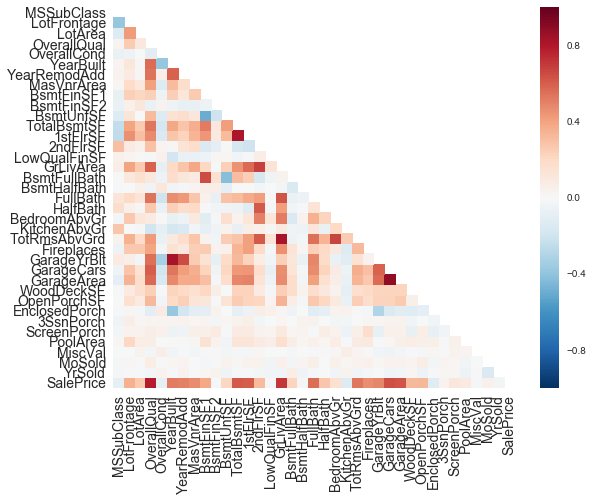

In [18]:
#Create heat map of correlation matrix to see if we can see anything useful
mean_corr = house.corr()

# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(9,7))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(mean_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(mean_corr, mask=mask, ax=ax)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

plt.show()

The above doesn't really tell us anything

In [19]:
house.LotFrontage.isnull().sum()

259

In [20]:
house.LotFrontage = house.LotFrontage.replace(np.NaN, 0)

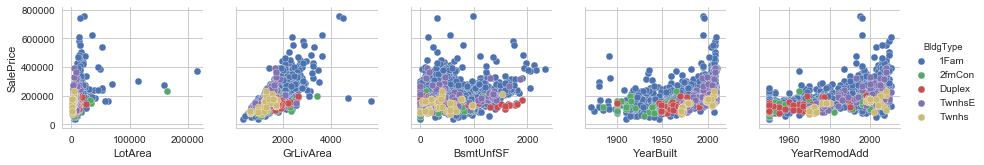

In [21]:
#To predict house prices let's build a pairplot to see if we can see any visual trends

#Create subset of variables we want to use
subset = house.loc[:,['SalePrice','LotArea', 'LotFrontage','GrLivArea', 'BsmtUnfSF','Condition1','YearBuilt','YearRemodAdd','TotalBsmtSF','BsmtCond','BsmtQual','GarageQual','GarageCond','GarageArea','PoolArea','OpenPorchSF','YrSold','BedroomAbvGr','KitchenQual','SaleCondition','Neighborhood','TotRmsAbvGrd','FullBath','OverallQual','OverallCond','BldgType','SaleType']]


sns.pairplot(data=subset,
                  y_vars=['SalePrice'],x_vars=['LotArea','GrLivArea','BsmtUnfSF','YearBuilt','YearRemodAdd'],hue='BldgType')
plt.show()

#Looks like LotArea, GrLivArea and YearRemodAdd have some outliers

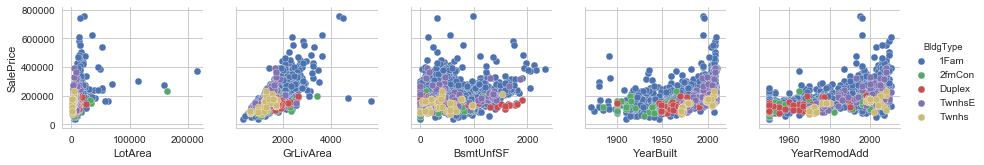

In [22]:
# Remove outliers

#subset = subset[subset.LotArea <= 20000]
#subset = subset[subset.GrLivArea <= 4000]
#subset = subset[subset.YearRemodAdd >= 1955]

#I was tempted to remove outliers above however I realized I was taking away nearly 250 rows which is rquivalent to ~17% of the data.

sns.pairplot(data=subset,
                  y_vars=['SalePrice'],x_vars=['LotArea','GrLivArea','BsmtUnfSF','YearBuilt','YearRemodAdd'],hue='BldgType')
plt.show()

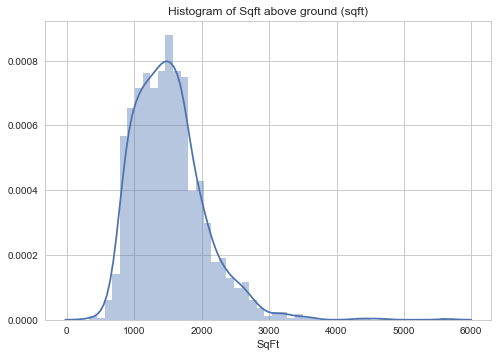

In [23]:
sns.distplot(subset.GrLivArea,hist=True)
plt.title('Histogram of Sqft above ground (sqft)')
plt.xlabel('SqFt')
plt.show()

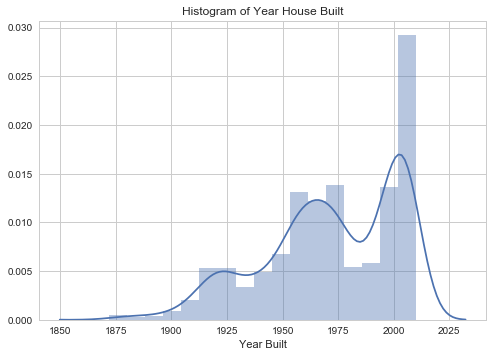

In [24]:
sns.distplot(subset.YearBuilt, hist=True)
plt.title('Histogram of Year House Built')
plt.xlabel('Year Built')
plt.show()
#Lack of additions below 1955 and between 1980-1990.  May need to bootstrap.


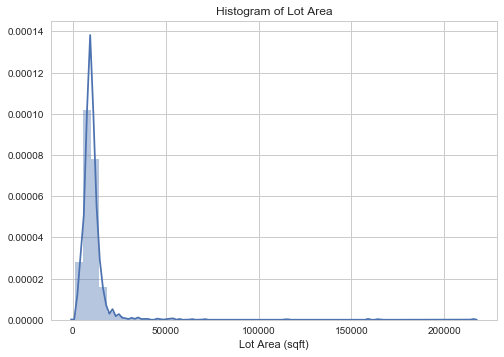

In [25]:
sns.distplot(subset.LotArea, hist=True)
plt.title('Histogram of Lot Area')
plt.xlabel('Lot Area (sqft)')
plt.show()

In [26]:
#Create train/test split of subset.  
#Training data set are houses sold prior to 2010 
#Test data set are houses sold in the year 2010

#Create train subset
train = subset[subset.YrSold < 2010]

#Create x_train and y_train set
#X_train = train[["GrLivArea","YearRemodAdd","YearBuilt", "GarageArea","TotalBsmtSF" ]].values
X_train = train[["GrLivArea","YearBuilt","GarageArea","TotalBsmtSF" ]].values
y_train = train[["SalePrice"]].values

#Create train subset
test = subset[subset.YrSold == 2010]

#Create x_test and y_test set.
#X_test = test[["GrLivArea","YearRemodAdd","YearBuilt", "GarageArea","TotalBsmtSF" ]].values
X_test = test[["GrLivArea","YearRemodAdd","GarageArea","TotalBsmtSF" ]].values
y_test = test[["SalePrice"]].values

In [27]:
#Although you could do this in scikit-learn I prefered to do this using statsmodel because of the statistical outputs.
import statsmodels.api as sm

#Create model using multi-linear regression on training data set
model = sm.OLS(y_train, X_train)
results = model.fit()

#Predict model on test data
x_pred = results.predict(X_train)
predictions = results.predict(X_test)

#View results of training model
prediction_error = y_test - predictions
print 'Average Prediction error on test data: $%s' % np.mean(prediction_error)
print''
#View Summary statistics
print results.summary()

Average Prediction error on test data: $2152.22226828

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     5483.
Date:                Tue, 13 Jun 2017   Prob (F-statistic):               0.00
Time:                        18:59:19   Log-Likelihood:                -15548.
No. Observations:                1278   AIC:                         3.110e+04
Df Residuals:                    1274   BIC:                         3.112e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------

## Comment 
Based on fixed inputs the training dataset is doing quite well with the prediction. If I had more time I would probably try elastic net to see if there is any improvement on the prediction.  Overall I am pretty happy with my prediction for the following reasons:
    1. R-squared > 0.90
    2. P values < 0.05
    3. Standard error for each element is pretty low
    4. My prediction error indicates I am over predicting house price by $2152.
 
Below I have plotted the training and test data sets versus predicted
First plot: Training vs Actual 
Second plot: Test vs Actual
 

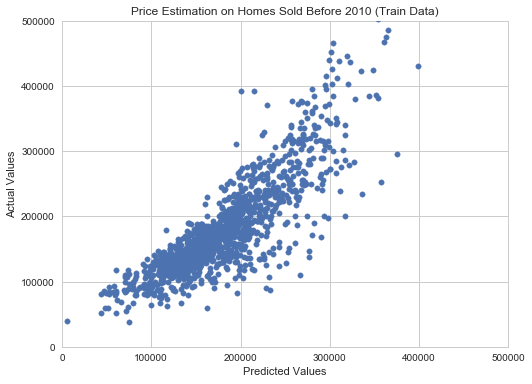

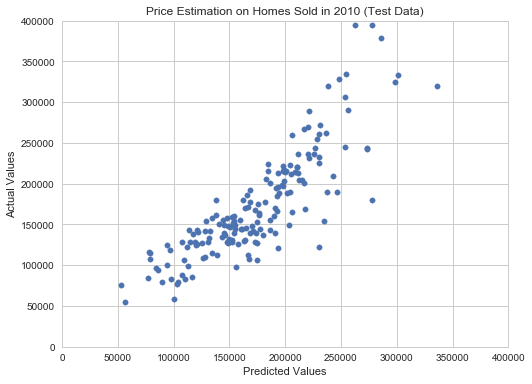

In [28]:
# Plot the training model
plt.figure(figsize=(8,6))
plt.scatter(x_pred, y_train, s=30, marker='o', zorder=10)
#plt.plot(predictions, y_test, 'r-', label="OLS")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")

plt.xlim([0,500000])
plt.ylim([0,500000])
#plt.xlabel("Predicted Values - $\hat{y_test}$")
#plt.ylabel("Actual Values - $y_test$")
plt.title("Price Estimation on Homes Sold Before 2010 (Train Data)")
plt.show()

# Plot the test model
plt.figure(figsize=(8,6))
plt.scatter(predictions, y_test, s=30, marker='o', zorder=10)
#plt.plot(predictions, y_test, 'r-', label="OLS")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")

plt.xlim([0,400000])
plt.ylim([0,400000])
#plt.xlabel("Predicted Values - $\hat{y_test}$")
#plt.ylabel("Actual Values - $y_test$")
plt.title("Price Estimation on Homes Sold in 2010 (Test Data)")
plt.show()

#Comment
Answers to question 1

1.Perform any cleaning, feature engineering, and EDA you deem necessary.
    
2.Be sure to remove any houses that are not residential from the dataset.

3.Identify fixed features that can predict price. In my example I used GrLivArea, YearRemodAdd and TotalBsmtSF

4.Train a model on pre-2010 data and evaluate its performance on the 2010 houses.

5.Characterize your model. How well does it perform? What are the best estimates of price?

In [29]:
#Multi-linear regresssion using statsmodel

#Do this twice.  Once for single family homes and again for dual family homes

#Single family homes
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

#Set predictor variables
#X = sfam[["GrLivArea","YearRemodAdd","LotArea","OpenPorchSF", "YearBuilt", "GarageArea","PoolArea","TotalBsmtSF" ]].values
X = sfam[["GrLivArea","YearRemodAdd","LotArea","YearBuilt", "GarageArea","TotalBsmtSF" ]].values
X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)

#Standardize variables
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Xs = ss.fit_transform(X)

#Set target variable y
y = sfam['SalePrice']

# Note the difference in argument order
# optionally, you can chain "fit()" to the model object
#model = sm.OLS.fit_regularized(y, X)
#model = model.fit_regularized(method='elastic_net')
model = sm.OLS(y, X)
model = model.fit()
predictions = model.predict(X)

# Plot the model
plt.figure(figsize=(8,6))
plt.scatter(predictions, y, s=30, marker='o', zorder=10)
#plt.plot(predictions, y, 'r-', label="OLS")
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - $y$")
plt.title("Price Estimation on Single Family Homes")
plt.show()

from sklearn.metrics import mean_squared_error

#print np.sqrt(mean_squared_error(y, predictions))
print model.summary()

NameError: name 'sfam' is not defined

In [ ]:
#Now apply to test set post 2010
print('Parameters: ', model.params)
print('R2: ', model.rsquared)

#y_pred = model.predict(x_test[subset])

In terms of predicting single family homes we can get a pretty good match where r2 is 0.81.  However one concern is the amount of inputs required.

When predicting dual family homes this becomes much more complicated.  There is much more spread at the high end of the price spectrum.  

If I had more time I might try and incorporate a logitic regression function with bathrooms or home condition.


In [30]:
#Same as above except for dual family homes

import statsmodels.api as sm

#Set predictor variables
#X = dfam[["GrLivArea","YearRemodAdd","LotArea","OpenPorchSF", "YearBuilt", "GarageArea","PoolArea","TotalBsmtSF" ]].values
X = dfam[["GrLivArea","YearRemodAdd","LotArea", "YearBuilt", "GarageArea","TotalBsmtSF" ]].values
X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)

#Standardize variables
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Xs = ss.fit_transform(X)

#Set target variable y
y = dfam['SalePrice']

# Note the difference in argument order
# optionally, you can chain "fit()" to the model object
model = sm.OLS(y, X)
model = model.fit()
#model = sm.OLS.fit_regularized(y, X)
#model = model.fit_regularized(method='elastic_net')
predictions = model.predict(X)

# Plot the model
plt.figure(figsize=(8,6))
plt.scatter(predictions, y, s=30, marker='o', zorder=10)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - $y$")
plt.title("Price Estimation on Single Family Homes")
plt.show()

from sklearn.metrics import mean_squared_error

#print np.sqrt(mean_squared_error(y, predictions))
print model.summary()

NameError: name 'dfam' is not defined

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [31]:
#To establish renovatable features we need to find a column that can divide the dataset into renovated vs non-renovated

#Create subset of houses that have been renovated.  The way we check is if 'YearBuilt' != 'YearRemoAdd'
reno = subset[subset.YearBuilt !=subset.YearRemodAdd]

#For some reason some houses that have been renovated are also considred new.  We want to exclude them SaleType != 'New'
reno = reno[reno.SaleType != 'New']

#Create subset of houses that have NOT been renovated ()'YearBuilt' == 'YearRemoAdd')
original = subset[subset.YearBuilt == subset.YearRemodAdd]
#Now remove houses that have SaleType == New because we do not want to include brand new homes.
original = original[original.SaleType != 'New']

In [32]:
reno.head()

,SalePrice,LotArea,LotFrontage,GrLivArea,BsmtUnfSF,Condition1,YearBuilt,YearRemodAdd,TotalBsmtSF,BsmtCond,...,BedroomAbvGr,KitchenQual,SaleCondition,Neighborhood,TotRmsAbvGrd,FullBath,OverallQual,OverallCond,BldgType,SaleType
2,223500,11250,68.0,1786,434,Norm,2001,2002,920,NaN,...,3,Gd,Normal,CollgCr,6,2,7,5,1Fam,WD
3,140000,9550,60.0,1717,540,Norm,1915,1970,756,NaN,...,3,Gd,Abnorml,Crawfor,7,1,7,5,1Fam,WD
5,143000,14115,85.0,1362,64,Norm,1993,1995,796,NaN,...,1,TA,Normal,Mitchel,5,1,5,5,1Fam,WD
6,307000,10084,75.0,1694,317,Norm,2004,2005,1686,NaN,...,3,Gd,Normal,Somerst,7,2,8,5,1Fam,WD
8,129900,6120,51.0,1774,952,Artery,1931,1950,952,NaN,...,2,TA,Abnorml,OldTown,8,2,7,5,1Fam,WD



My methodology is to calcualte the dollar per sqft for all renovated and non renovated houses.  Then compare average  between the two subsets to get an idea of the incremental uptick when renovating.


In [33]:
#Calucalte $/sqft value of renovated and non renovated houses
#Create new column to add $/sqft in reno and original subsets
reno['dpsqft'] = reno.SalePrice/reno.GrLivArea
original['dpsqft'] = original.SalePrice/original.GrLivArea

#Calculate summary stats of dollar per sqft in reno and original
print 'Summary stats of $/sqft for Original houses excluding new builds'
print original.dpsqft.describe()
print ''
print 'Summary stats of $/sqft for Renovated houses'
print reno.dpsqft.describe()

Summary stats of $/sqft for Original houses excluding new builds
count    694.000000
mean     122.531602
std       25.709093
min       47.021944
25%      106.593704
50%      122.667984
75%      138.256418
max      231.057452
Name: dpsqft, dtype: float64

Summary stats of $/sqft for Renovated houses
count    634.000000
mean     112.842501
std       30.751056
min       38.510911
25%       91.849959
50%      110.522318
75%      131.813722
max      216.208477
Name: dpsqft, dtype: float64


We have a problem!

The average price of renovated house is lower than non-renovated which does not make sense.  
There are either problems in the data or the grouping is too generalized.  This may not be accounting for market forces like time of sale or location or somethingelse I have not thought of.

Let's look at the dollar/sqft values when we group by 'OverallCond'

OverallQual
1      92.571273
2     105.993151
3      80.644629
4     104.243659
5     112.896056
6     114.496555
7     124.494470
8     144.511059
9     178.693921
10    160.423437
Name: dpsqft, dtype: float64


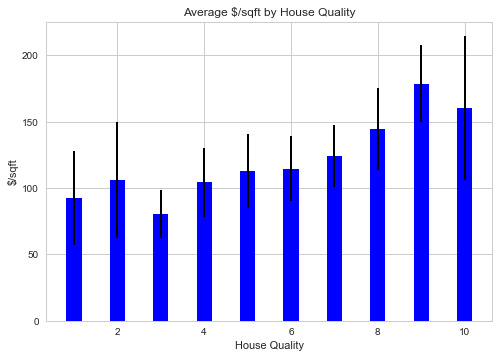

In [34]:
#Use groupby function to filter dollar/sqft by 'OverallQual' then calcualte the mean
subset['dpsqft'] = subset.SalePrice/subset.GrLivArea

#print 'Average $/sqft ranked by Condition'
print subset.groupby('OverallQual').dpsqft.mean()

#Calculate the median to compare and see if there are any major differences.  
#Didn't see any signifigant difference to mean so its commented out

#print 'Median $/sqft ranked by Condition'
#print subset.groupby('OverallQual').dpsqft.median()


#Plot Bar chart of House Quality vs Dollar/sqft
xbar = np.sort(subset.OverallQual.unique())
ybar = subset.groupby('OverallQual').dpsqft.mean().values
std_dev = subset.groupby('OverallQual').dpsqft.std().values

#plt.bar(xbar,ybar,0.35,color='blue')
plt.bar(xbar,ybar,0.35,color='blue',yerr=std_dev, error_kw=dict(elinewidth=2,ecolor='black'))

plt.title('Average $/sqft by House Quality')
plt.xlabel('House Quality')
plt.ylabel('$/sqft')

plt.show()

The calculation and bar chart above suggests that the house quality representing the best value for home renovation are 3 and 8.  By making changes and improving by just one category one would expect an average improvement of around $27-$34 per squarefoot.

Alternatively if your house was ranked in category 4,5,6 or 7 there is very little improvement from one category to another.  So one would have to improve at least two categories to see any real value of a renovation.

Something that needs more work with this philospohy is the error bars associated with each category and the amount of effort required to renovate.  It's entirely possible that the effory level required to renovate to improve one category is the same as moving up 3 categories.

Using the information above I would target houses in category 3 that have an average dollar/sqft value less than the $80/sqft.  These houses would represent the greatest renovation potential with the lowest risk.

In [35]:
#prospects = subset[(subset.OverallQual==3) & (subset.dpsqft <= 80) & (subset.GrLivArea > 1000)]
prospects = subset[(subset.OverallQual==3) & (subset.dpsqft <= 80)]

prospects

,SalePrice,LotArea,LotFrontage,GrLivArea,BsmtUnfSF,Condition1,YearBuilt,YearRemodAdd,TotalBsmtSF,BsmtCond,...,KitchenQual,SaleCondition,Neighborhood,TotRmsAbvGrd,FullBath,OverallQual,OverallCond,BldgType,SaleType,dpsqft
74,107400,5790,60.0,1605,840,Norm,1915,1950,840,NaN,...,TA,Normal,OldTown,8,2,3,6,1Fam,WD,66.915888
250,76500,5350,55.0,1306,728,Norm,1940,1966,728,NaN,...,Fa,Normal,BrkSide,6,1,3,2,1Fam,WD,58.575804
620,67000,8248,45.0,864,823,Norm,1914,1950,864,NaN,...,TA,Normal,Edwards,5,1,3,3,1Fam,WD,77.546296
710,52000,4130,56.0,729,270,Norm,1935,2003,270,NaN,...,TA,Normal,BrkSide,5,1,3,6,1Fam,WD,71.330590
968,37900,5925,50.0,968,600,Norm,1910,1950,600,NaN,...,TA,Abnorml,OldTown,6,1,3,6,1Fam,WD,39.152893
1186,95000,10615,107.0,1699,538,Artery,1900,1970,978,NaN,...,TA,Abnorml,OldTown,7,2,3,5,2fmCon,WD,55.915244
1380,58500,8212,45.0,864,661,Norm,1914,1950,864,NaN,...,TA,Normal,Edwards,5,1,3,3,1Fam,WD,67.708333


The list above represents seven homes that I would target for potential renovation.  If we had more personal knowledge of the Neighborhoods we might be able to refine this list even more. 

In [36]:
subset.KitchenQual.unique()

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

KitchenQual
Ex    160.130585
Fa     92.119419
Gd    129.936768
TA    109.810815
Name: dpsqft, dtype: float64


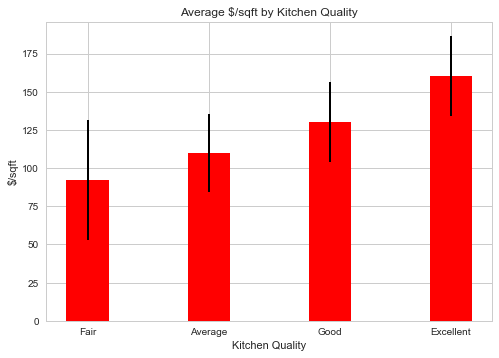

In [37]:
#Let's have a look at average $/sqft vs KitchenQuality

#Use groupby function to calculate $/sqft for each category in Kitchen Quality
print subset.groupby('KitchenQual').dpsqft.mean()
N = 4
ind = np.arange(N)
label = ['Fair','Average','Good','Excellent']
ybar = np.sort(subset.groupby('KitchenQual').dpsqft.mean().values)
std_dev = subset.groupby('KitchenQual').dpsqft.std().values


#plt.bar(xbar,ybar,0.35,color='red')
plt.bar(ind,ybar,0.35,color='red',yerr=std_dev, error_kw=dict(elinewidth=2,ecolor='black'))

plt.title('Average $/sqft by Kitchen Quality')
plt.xlabel('Kitchen Quality')
plt.xticks(ind,label)
plt.ylabel('$/sqft')

plt.show()

The bar chart would suggest that the best target for renovations are homes with kitchens ranked in the 'Good' category.  This would have the safest return on investment.

In [38]:
#Using the same methodology as above.

k_reno = subset[(subset.KitchenQual=='Gd') & (subset.dpsqft <= 125)]

k_reno.shape

(253, 28)

In [39]:
#In this case I have identified 253 kitchens that could benefit from a renovation.

## Answer to question 3: 
Investigate how much of the variance in price remaining is explained by these features.
Going back to the bar chart of houses grouped by over all qulaity I have displayed the error within each category.  When looking at the error one can observe that there is overlap between categories.  This is why I said to target houses that are below the mean within the category.


## Answer to question 4: 
Do you trust your model? 
As a first pass in identifying potential houses yes.  But further research would be required to assess the properties.  Seeing the properties with your own eyes provides the best evaluaiton.


Should it be used to evaluate which properties to buy and fix up?
In the first part of question 2 I think the model does a good job of identifying houses that have renovation potential however this does not take into account other factors like neighborhood, amenities, crime, etc.  At the end of the day it identified a list of houses and it would be upto a real estate agent to scope them out to assess.  This model is appropriate as a first step filter.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [40]:
#To predict Abnormal sales let's use logistical regression.

#Set all 'Abnorml' values to binary where 1=Abnormal and 0= Not
SaleCond_dummies = pd.get_dummies(subset.SaleCondition)

#Set target varibale
y = SaleCond_dummies.Abnorml.values

#Set predictor variables. If I had more time I would try feature selection or gridsearch
X = subset[['SalePrice','LotArea','GrLivArea','YearBuilt','YearRemodAdd','PoolArea','OverallQual','OverallCond','YrSold']]

X.values

array([[208500,   8450,   1710, ...,      7,      5,   2008],
       [181500,   9600,   1262, ...,      6,      8,   2007],
       [223500,  11250,   1786, ...,      7,      5,   2008],
       ..., 
       [266500,   9042,   2340, ...,      7,      9,   2010],
       [142125,   9717,   1078, ...,      5,      6,   2010],
       [147500,   9937,   1256, ...,      5,      6,   2008]])

In [41]:
X.columns

Index([u'SalePrice', u'LotArea', u'GrLivArea', u'YearBuilt', u'YearRemodAdd',
       u'PoolArea', u'OverallQual', u'OverallCond', u'YrSold'],
      dtype='object')

In [42]:
X.dtypes

SalePrice       int64
LotArea         int64
GrLivArea       int64
YearBuilt       int64
YearRemodAdd    int64
PoolArea        int64
OverallQual     int64
OverallCond     int64
YrSold          int64
dtype: object

In [43]:
abnrml_values = sum([x for x in y if x==1])
print abnrml_values
subset.shape

96


(1450, 28)

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.grid_search import GridSearchCV


/Users/gopetro/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/gopetro/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [45]:
# baseline:
print np.mean(y)

0.0662068965517


In [46]:
#This is really low since most data points are equal to normal where normal=0

In [47]:
#Standardize variables
ss = StandardScaler()
Xs = ss.fit_transform(X)

In [1204]:
from sklearn.model_selection import cross_val_score

lr = LogisticRegression()

# using a 25-fold cross-val for fun
scores = cross_val_score(lr, Xs, y, cv=25)
print scores
print np.mean(scores)

[ 0.93220339  0.93220339  0.93220339  0.93220339  0.93103448  0.93103448
  0.93103448  0.93103448  0.93103448  0.93103448  0.93103448  0.93103448
  0.93103448  0.93103448  0.93103448  0.93103448  0.93103448  0.93103448
  0.93103448  0.93103448  0.93103448  0.94736842  0.92982456  0.94736842
  0.94736842]
0.933133183631


In [1205]:
#The above is higher than baseline accuracy but remember that we have quite high class imbalance.

In [87]:
# Train Test Split our data using a 50/50 split.
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=12)
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.5)

In [88]:
#Compute logisitc regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_pp = lr.predict_proba(X_test)

In [89]:
y_pred_pp[0:5]

array([[ 0.87375686,  0.12624314],
       [ 0.90414779,  0.09585221],
       [ 0.94821252,  0.05178748],
       [ 0.92978497,  0.07021503],
       [ 0.91225259,  0.08774741]])

In [90]:
#from sklearn.metrics import confusion_matrix

confusion = np.array(confusion_matrix(y_test, y_pred))

print(confusion)

[[680   0]
 [ 45   0]]


In [91]:
# calculate true positives, the number of 1s correctly predicted to be 1
TP = confusion[0,0]

# calculate false positives, the number of 0s incorrectly predicted to be 1
FP  = confusion[1,0]

# calculate true negatives, the number of 0s correctly predicted to be 0
TN = confusion[1,1]

# calculate false negatives, the number of 1s incorrectly predicted to be 0
FN = confusion[0,1]

In [92]:
conmat = np.array(confusion_matrix(y_test, y_pred, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['Abnormal', 'Normal'],
                         columns=['predicted_Abnormal','predicted_Normal'])
confusion

,predicted_Abnormal,predicted_Normal
Abnormal,0,45
Normal,0,680


## Comment
There are too few abnormal house sales that the prediciton is unable to account for this.  

In [93]:
# Classification Report

#Printout:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.94      1.00      0.97       680
          1       0.00      0.00      0.00        45

avg / total       0.88      0.94      0.91       725



## Comment
Due to class imbalance I am unable to predict Abnormal sales as there are too many zeroes.  Let's try lowering the threshold


In [94]:
pp = pd.DataFrame(y_pred_pp, columns=['normal','abnormal'])
pp.head()

,normal,abnormal
0,0.873757,0.126243
1,0.904148,0.095852
2,0.948213,0.051787
3,0.929785,0.070215
4,0.912253,0.087747


In [95]:
# In order to do this, we can lower the threshold for predicting class 1.
# This will reduce our false negative rate to 0, but at the expense of a higher false positive rate.

pp['pred_class_thresh10'] = [1 if x >= 0.1 else 0 for x in pp.abnormal.values]
pp.head(10)

,normal,abnormal,pred_class_thresh10
0,0.873757,0.126243,1
1,0.904148,0.095852,0
2,0.948213,0.051787,0
3,0.929785,0.070215,0
4,0.912253,0.087747,0
5,0.940155,0.059845,0
6,0.891176,0.108824,1
7,0.948123,0.051877,0
8,0.909436,0.090564,0
9,0.944380,0.055620,0


In [96]:
print y_test.shape
print pp.shape

(725,)
(725, 3)


In [99]:
conmat_thresh = np.array(confusion_matrix(y_test, pp.pred_class_thresh10.values, labels=[1,0]))

confusion_thresh = pd.DataFrame(conmat_thresh, index=['Abnormal', 'Normal'],
                         columns=['predicted_Abnormal','predicted_Normal'])
print 'confusion matrix with lowered threshold'
confusion_thresh

confusion matrix with lowered threshold


,predicted_Abnormal,predicted_Normal
Abnormal,15,30
Normal,112,568


In [119]:
#Compare to original before lowering threshold
print 'confusion matrix Original'
confusion

confusion matrix Original


,predicted_Abnormal,predicted_Normal
Abnormal,0,45
Normal,0,680


In [120]:
#After lowering the threshold we have improved the amount of abnormal predictions.  However this comes at the expense of increases False negatives

#The results produced for this question were very much taken from lesson 5.5.1 Evaluating Classifiers: Confusion Matrix and AUD and ROC.
#Credit Kiefer Katovich & Joseph Nelson


In [121]:
pp.head()

,normal,abnormal,pred_class_thresh10
0,0.873757,0.126243,1
1,0.904148,0.095852,0
2,0.948213,0.051787,0
3,0.929785,0.070215,0
4,0.912253,0.087747,0


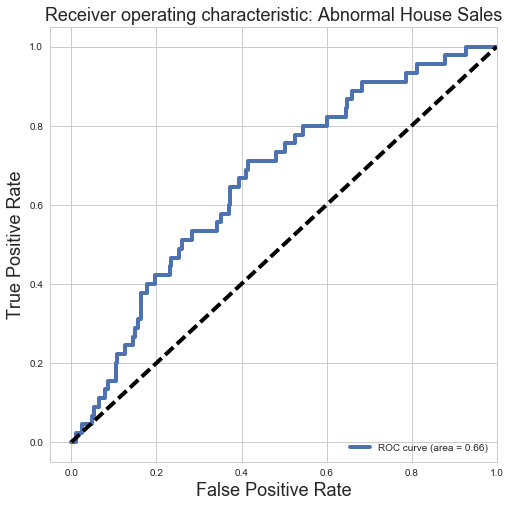

In [182]:
#ROC/AUC plot of the original and threshold
from sklearn.metrics import roc_curve, auc

#fpr, tpr, _ = roc_curve(y_test, pp.abnormal)
fpr, tpr, _ = roc_curve(y_test, y_pred_pp[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: Abnormal House Sales', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [183]:
#Not working

# fpr, tpr, _ = roc_curve(y_test, y_pred_pp[:,1])
# fpr_t, tpr_t, _ = roc_curve(y_test, pp.pred_class_thresh10)
# roc_auc = auc(fpr, tpr)
# roc_auc_t = auc(fpr_t, tpr_t)

# plt.figure(figsize=[8,8])
# plt.plot(fpr, tpr, label='Original (area = %0.2f)' % roc_auc, linewidth=4)
# plt.plot(fpr_t, tpr_t, label='Thresh10 (area = %0.2f)' % roc_auc_t, linewidth=4)
# plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
# plt.xlim([-0.05, 1.0])
# plt.ylim([-0.05, 1.05])
# plt.xlabel('False Positive Rate', fontsize=18)
# plt.ylabel('True Positive Rate', fontsize=18)
# plt.title('Receiver operating characteristic: Abnormal Sales', fontsize=18)
# plt.legend(loc="lower right")
# plt.show()

In [184]:
#Now lets try Lasso using the threshold

from sklearn.linear_model import LogisticRegressionCV

#lr_lasso = LogisticRegressionCV(penalty='l2', solver='liblinear', Cs=100, cv=10)
#lr_lasso.fit(X_train, y_train)

lr_ridge = LogisticRegressionCV(penalty='l2', Cs=200, cv=25)
lr_ridge.fit(X_train, y_train)

LogisticRegressionCV(Cs=200, class_weight=None, cv=25, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [185]:
yhat_ridge = lr_ridge.predict(X_test)
yhat_ridge_pp = lr_ridge.predict_proba(X_test)

conmat = np.array(confusion_matrix(y_test, yhat_ridge, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['Abnormal', 'Normal'],
                         columns=['predicted_Abnormal','predicted_Normal'])
confusion

,predicted_Abnormal,predicted_Normal
Abnormal,0,45
Normal,0,680


In [186]:
print(classification_report(y_test, yhat_ridge))

             precision    recall  f1-score   support

          0       0.94      1.00      0.97       680
          1       0.00      0.00      0.00        45

avg / total       0.88      0.94      0.91       725



In [187]:
yhat_ridge_pp[0:5]

array([[ 0.92920305,  0.07079695],
       [ 0.92918118,  0.07081882],
       [ 0.92987321,  0.07012679],
       [ 0.92963405,  0.07036595],
       [ 0.92932723,  0.07067277]])

In [188]:
#Just like the logisitic regression the abnormal predicted is no good.  Need to try lowering the threshold


In [189]:
yhat_ridge_pp = pd.DataFrame(yhat_ridge_pp, columns=['Normal','Abnormal'])
#pp = pd.DataFrame(y_pred_pp, columns=['Normal','Abnormal'])

In [190]:
#Lower threshold
yhat_ridge_pp['pred_class_thresh10'] = [1 if x >= 0.1 else 0 for x in yhat_ridge_pp.Abnormal.values]
print yhat_ridge_pp.head(10)

     Normal  Abnormal  pred_class_thresh10
0  0.929203  0.070797                    0
1  0.929181  0.070819                    0
2  0.929873  0.070127                    0
3  0.929634  0.070366                    0
4  0.929327  0.070673                    0
5  0.929614  0.070386                    0
6  0.929228  0.070772                    0
7  0.929853  0.070147                    0
8  0.929343  0.070657                    0
9  0.929506  0.070494                    0


In [191]:
conmat = np.array(confusion_matrix(y_test, yhat_ridge_pp.pred_class_thresh10.values, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['Abnormal', 'Normal'],
                         columns=['predicted_Abnormal','predicted_Normal'])
confusion

,predicted_Abnormal,predicted_Normal
Abnormal,0,45
Normal,0,680


In [192]:
#At least now we are predicting abnormal sales but notice we are also introducing additional false positives

In [193]:
#fpr_lasso, tpr_lasso, _ = roc_curve(y_test, yhat_lasso_pp[:,1])

#fpr_lasso, tpr_lasso, _ = roc_curve(y_test, yhat_lasso_pp.pred_class_thresh10)
#roc_auc_lasso = auc(fpr_lasso, tpr_lasso)

fpr_ridge, tpr_ridge, _ = roc_curve(y_test, yhat_ridge_pp.Abnormal)
roc_auc_ridge = auc(fpr_lasso, tpr_lasso)

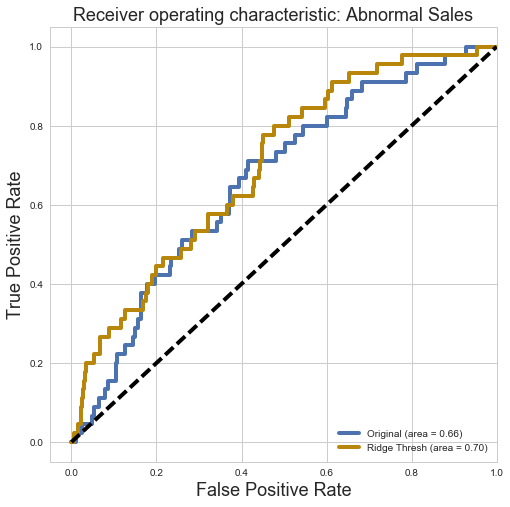

In [194]:
#Plot all the ROC/AUC curves we generated

plt.figure(figsize=[8,8])

plt.plot(fpr, tpr, label='Original (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot(fpr_ridge, tpr_ridge, label='Ridge Thresh (area = %0.2f)' % roc_auc_ridge, 
         linewidth=4, color='darkgoldenrod')
#plt.plot(fpr_t, tpr_t, label='Thresh (area = %0.2f)' % roc_auc_t, 
#         linewidth=4, color='darkred')

plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: Abnormal Sales', fontsize=18)
plt.legend(loc="lower right")
plt.show()

Due to imbalance using the original logisitic regression does not predict any abnormal houses.  It's not displayed here but the same holds true if we run a straight up Lasso regression as well.  So to get any abnormal predictors we have to lower the threshold.  The problem is that when we lower the threshold we start to increase the amount of flase positives.  From the three regressions I tried the best result appears to be the Lasso regression with a lower threshold.  Although the original looks the best it is not predicting any abnormal values so its kind of useless.

If I had moe time I would also try ridge and elastic net to see if there is any better improvment.  Perhaps changing the input predictors might also result in a better prediction.
